In [21]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c) Pré-processamento dos Dados

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Carregar os dados
df = pd.read_csv('./data/generated/final-dataset.csv')

# Selecionar colunas relevantes
features = ['Coal (TWh)', 'Gas (TWh)', 'Oil (TWh)', 'Nuclear (TWh)', 'Hydro (TWh)', 'Solar (TWh)', 'Wind (TWh)']
target = 'Total (CO₂)'

# Preencher valores ausentes com 0
df[features] = df[features].fillna(0)

# Filtrar dados completos
df = df.dropna(subset=[target])

# Separar variáveis e target
X = df[features]
y = df[target]

# Dividir dados: 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Análise Exploratória dos Dados

1. Série temporal de emissões globais de CO₂: mostra o total anual de emissões mundiais de CO₂.

C:\Users\Lucas Andrin\AppData\Local\Temp\ipykernel_13664\915649102.py:45: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Lucas Andrin\Documents\IFC\CD\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


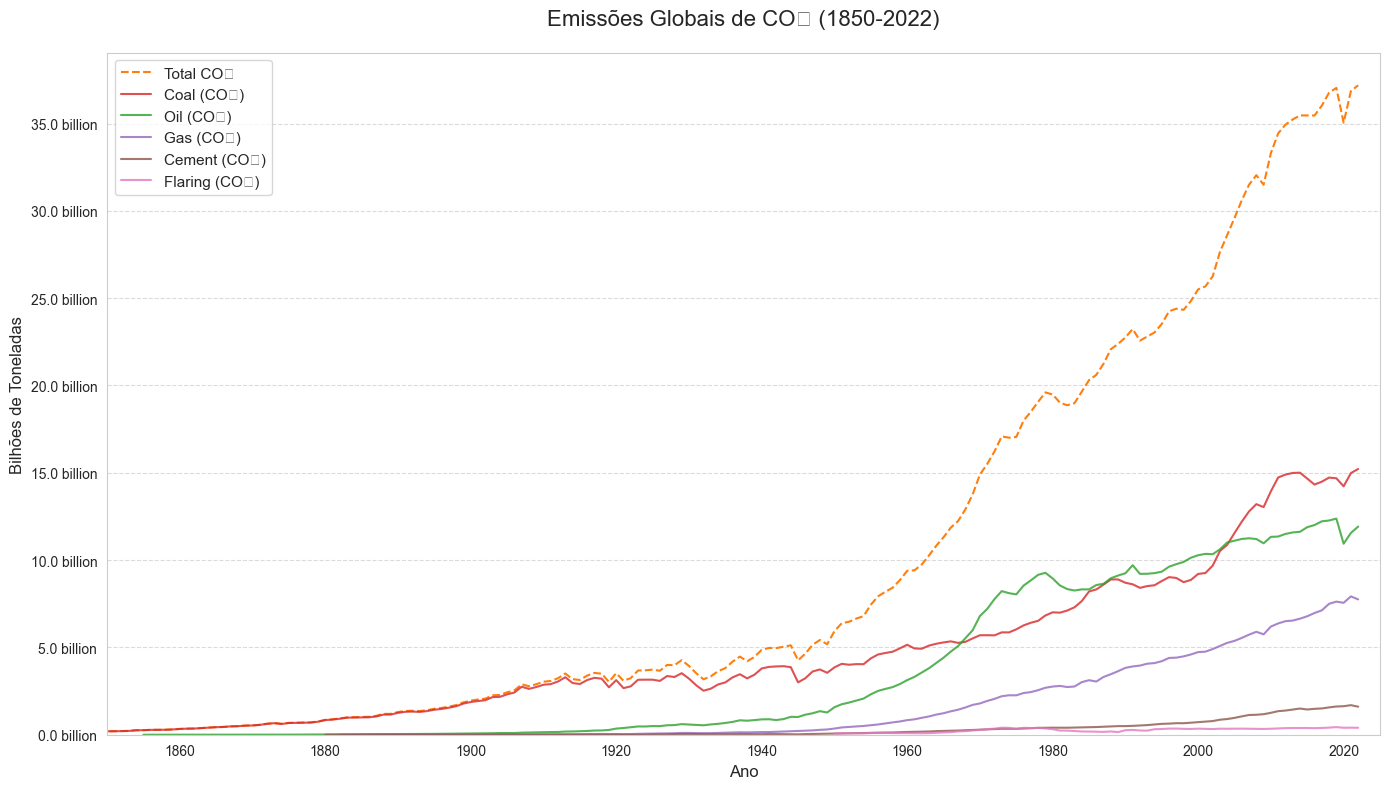

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

dfco2 = pd.read_csv('./data/generated/gen-co2-emissions.csv')

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

def format_billions(value, pos):
    return f'{value/1e9:.1f} billion'

# Filtrar apenas dados globais (World)
dfwco2 = dfco2[dfco2['Entity'] == 'World'].copy()
dfwco2 = dfwco2.sort_values('Year')

# Configurar estilo SEM grid vertical
sns.set_style("whitegrid", {'axes.grid': True, 'axes.grid.axis': 'y'})  # Grid apenas no eixo Y
plt.figure(figsize=(14, 8))

# Plotar GHG e Total CO₂
# plt.plot(dfwe['Year'], dfwe['GHG'], label='Total GHG', color='#1f77b4', linewidth=2)
plt.plot(dfwco2['Year'], dfwco2['Total (CO₂)'], label='Total CO₂', color='#ff7f0e', linestyle='--', linewidth=1.5)

# Plotar fontes específicas de CO₂
co2_sources = ['Coal (CO₂)', 'Oil (CO₂)', 'Gas (CO₂)', 'Cement (CO₂)', 'Flaring (CO₂)']
cores = ['#d62728', '#2ca02c', '#9467bd', '#8c564b', '#e377c2']

for fonte, cor in zip(co2_sources, cores):
    plt.plot(dfwco2['Year'], dfwco2[fonte], label=fonte, color=cor, alpha=0.8)

# Configurações do gráfico
plt.title('Emissões Globais de CO₂ (1850-2022)', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Bilhões de Toneladas', fontsize=12)
plt.xlim(1850, 2025)
plt.ylim(bottom=0)
plt.legend(title_fontsize=12, fontsize=11)

# Configurar grid APENAS horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Somente linhas horizontais
plt.grid(axis='x', visible=False)
plt.gca().yaxis.set_major_formatter(format_billions)  # Formatação corrigida

plt.tight_layout()
plt.show()

C:\Users\Lucas Andrin\AppData\Local\Temp\ipykernel_13664\1907896045.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfwen = dfen[dfen['Entity'] == 'World'][dfen['Year'] >= 1995].copy()


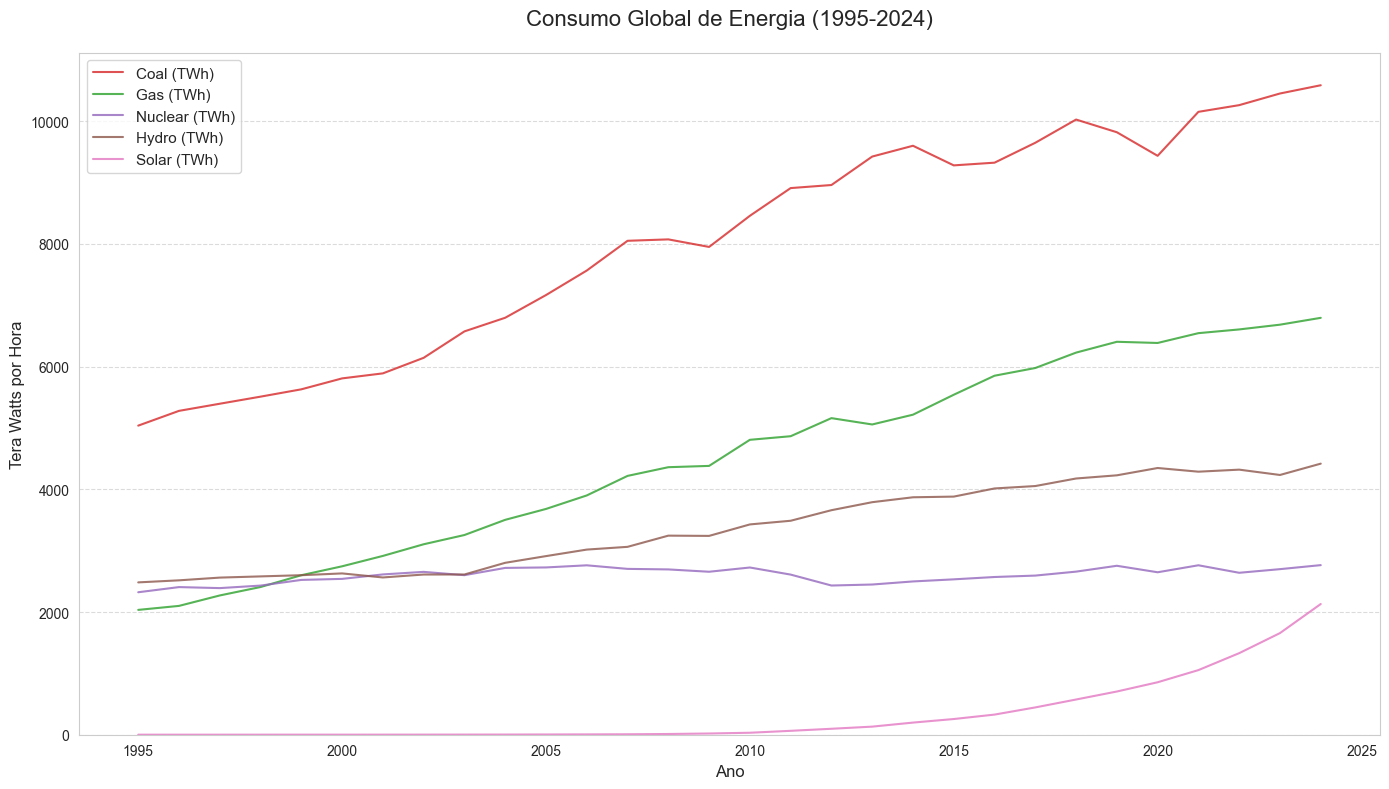

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

dfen = pd.read_csv('./data/generated/gen-electricity-sources.csv')

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar apenas dados globais (World)
dfwen = dfen[dfen['Entity'] == 'World'][dfen['Year'] >= 1995].copy()
dfwen = dfwen.sort_values('Year')

# Configurar estilo SEM grid vertical
sns.set_style("whitegrid", {'axes.grid': True, 'axes.grid.axis': 'y'})  # Grid apenas no eixo Y
plt.figure(figsize=(14, 8))

# Plotar fontes específicas de energia
energy_sources = ['Coal (TWh)', 'Gas (TWh)', 'Nuclear (TWh)', 'Hydro (TWh)', 'Solar (TWh)', 'Oil (TWh)', 'Wind (TWh)', 'Bioenergy (TWh)', 'Other renewables excluding bioenergy - TWh']
cores = ['#d62728', '#2ca02c', '#9467bd', '#8c564b', '#e377c2']

for fonte, cor in zip(energy_sources, cores):
    plt.plot(dfwen['Year'], dfwen[fonte], label=fonte, color=cor, alpha=0.8)

min_year = dfwen['Year'].min()
max_year = dfwen['Year'].max()

# Configurações do gráfico
plt.title(f'Consumo Global de Energia ({min_year}-{max_year})', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Tera Watts por Hora', fontsize=12)
plt.ylim(bottom=0)
plt.legend(title_fontsize=12, fontsize=11)

# Configurar grid APENAS horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Somente linhas horizontais
plt.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()

3. Teste de Algoritmos de Regressão

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Modelos a serem testados
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf')
}

# Treinar e avaliar modelos
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "R²": r2}
results

{'Random Forest': {'RMSE': np.float64(162242682.5103633),
  'R²': 0.9953859963890113},
 'Gradient Boosting': {'RMSE': np.float64(176408894.71565017),
  'R²': 0.994545076664865},
 'SVR': {'RMSE': np.float64(2407685121.077499), 'R²': -0.0161248473361979}}

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Métricas de Desempenho:
RMSE: 139,188,491.52
MAE: 38,924,692.02
R²: 0.9966


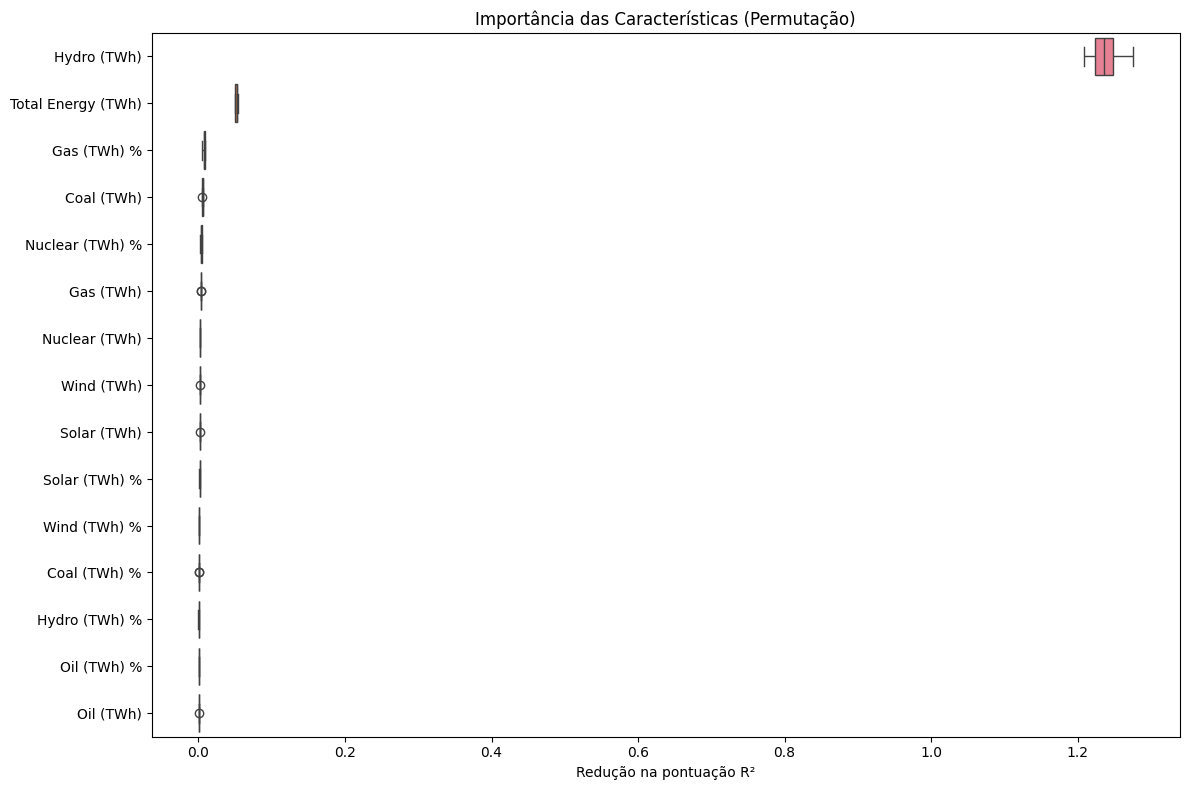

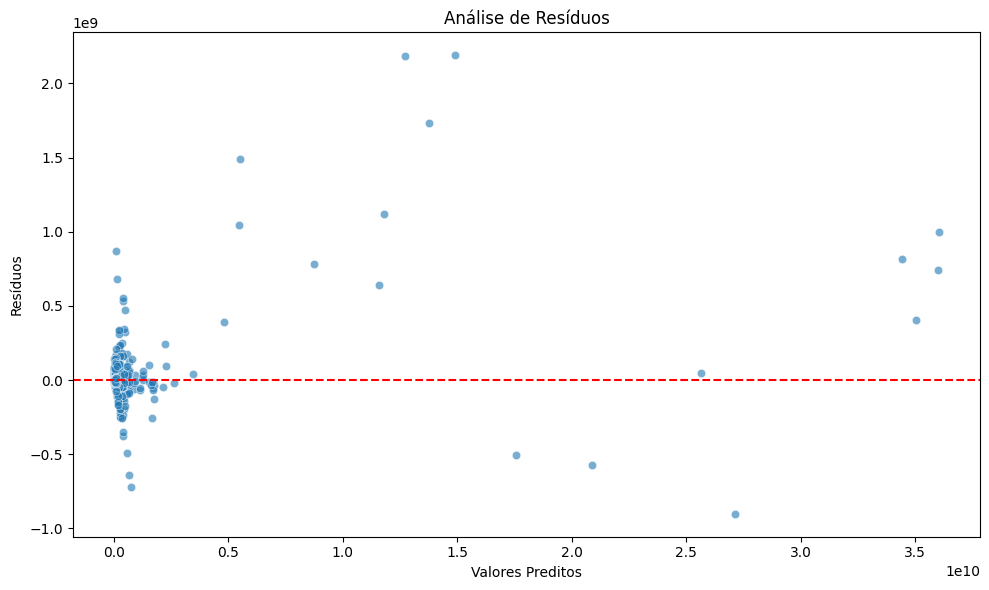

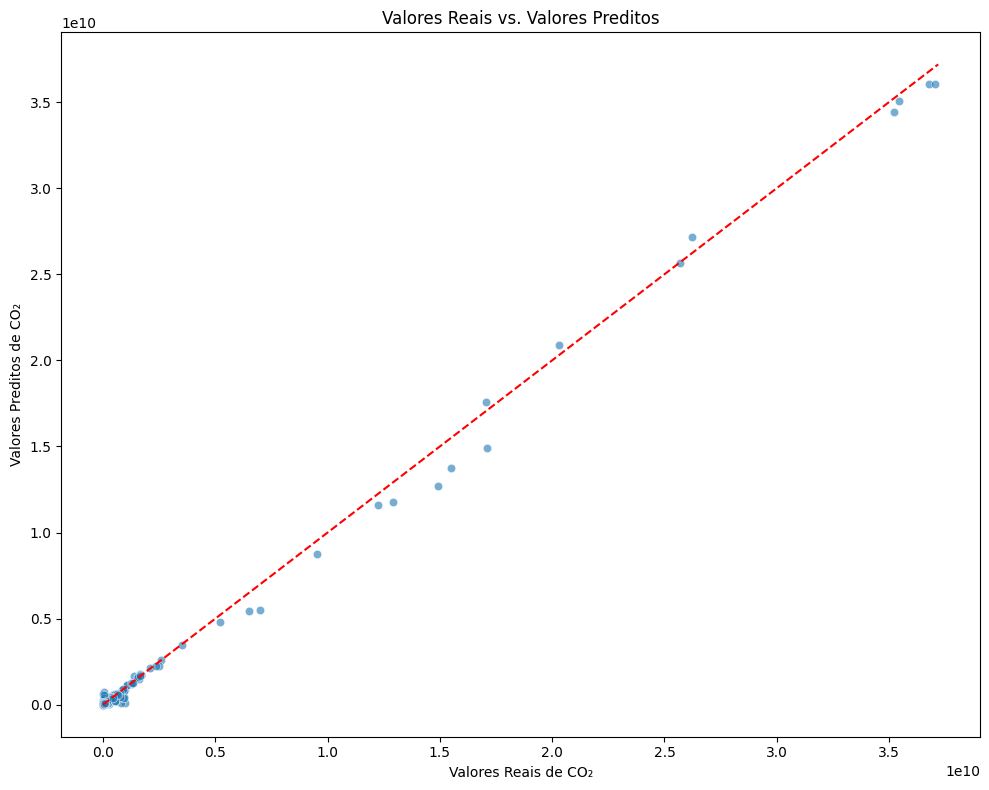


Modelo e scaler salvos com sucesso!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# Carregar os dados
df = pd.read_csv('./data/generated/final-dataset.csv')

# 1. Pré-processamento de dados
# Preencher valores ausentes com 0
energy_columns = ['Coal (TWh)', 'Gas (TWh)', 'Oil (TWh)', 'Nuclear (TWh)', 'Hydro (TWh)', 'Solar (TWh)', 'Wind (TWh)']
df[energy_columns] = df[energy_columns].fillna(0)

# Filtrar dados completos para emissão de CO₂
df = df.dropna(subset=['Total (CO₂)'])

# 2. Engenharia de características
# Criar variável de energia total
df['Total Energy (TWh)'] = df[energy_columns].sum(axis=1)

# Calcular proporções de cada fonte
for col in energy_columns:
    df[f'{col} %'] = df[col] / df['Total Energy (TWh)']

# Substituir infinitos por 0
df = df.replace([np.inf, -np.inf], 0).fillna(0)

# 3. Seleção de características
features = energy_columns + ['Total Energy (TWh)'] + [f'{col} %' for col in energy_columns]
target = 'Total (CO₂)'

X = df[features]
y = df[target]

# 4. Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Treinamento do modelo Random Forest com ajuste de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Melhores parâmetros encontrados
best_params = grid_search.best_params_
print(f"Melhores parâmetros: {best_params}")

# Treinar modelo final com melhores parâmetros
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_scaled, y_train)

# 7. Avaliação do modelo
y_pred = best_rf.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas de Desempenho:")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"R²: {r2:.4f}")

# 8. Análise de importância das características
# Importância baseada em permutação (mais confiável)
result = permutation_importance(
    best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()[::-1]
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx]
)

# Plotar importância das características
plt.figure(figsize=(12, 8))
sns.boxplot(data=importances, orient="h")
plt.title("Importância das Características (Permutação)")
plt.xlabel("Redução na pontuação R²")
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# 9. Análise de resíduos
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Análise de Resíduos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.tight_layout()
plt.savefig('residuals_analysis.png', dpi=300)
plt.show()

# 10. Comparação de valores reais vs. preditos
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Valores Reais vs. Valores Preditos")
plt.xlabel("Valores Reais de CO₂")
plt.ylabel("Valores Preditos de CO₂")
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300)
plt.show()

# 11. Salvar modelo para uso futuro
import joblib
joblib.dump(best_rf, 'co2_emission_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\nModelo e scaler salvos com sucesso!")